# Analysis of data from B. Toner, taken at ALS

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as patches

import os
import pandas as pd

from sklearn.linear_model import LinearRegression

from importlib import reload
import utils
utils = reload(utils)
from utils import *

import mantis_xray

np.random.seed(42)

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
   return false;
}

<IPython.core.display.Javascript object>

# Data I/O

In [5]:
directory = "Data/ALS_Toner/71214098_FigS3/Aligned/"
datafiles = [fname for fname in os.listdir(directory) if fname.endswith('.xim')]
Data = []
for dfile in datafiles:
    img = np.loadtxt(directory + dfile)
    Data.append(img)
Data = np.array(Data)
Data.shape

(123, 150, 150)

In [6]:
Energy = [700.000, 700.375, 700.750, 701.125, 701.500, 
          701.875, 702.250, 702.625, 703.000, 703.202, 
          703.404, 703.606, 703.808, 704.010, 704.212, 
          704.414, 704.616, 704.818, 705.020, 705.222, 
          705.424, 705.626, 705.828, 706.030, 706.232, 
          706.434, 706.636, 706.838, 707.040, 707.242, 
          707.444, 707.646, 707.848, 708.050, 708.252, 
          708.454, 708.656, 708.858, 709.060, 709.262, 
          709.464, 709.666, 709.868, 710.070, 710.272, 
          710.474, 710.676, 710.878, 711.080, 711.282, 
          711.484, 711.686, 711.888, 712.090, 712.292, 
          712.494, 712.696, 712.898, 713.100, 713.302, 
          713.504, 713.706, 713.908, 714.110, 714.312, 
          714.514, 714.716, 714.918, 715.120, 715.322, 
          715.524, 715.726, 715.928, 716.130, 716.332, 
          716.534, 716.736, 716.938, 717.140, 717.342, 
          717.544, 717.746, 717.948, 718.150, 718.352, 
          718.554, 718.756, 718.958, 719.160, 719.362, 
          719.564, 719.766, 719.968, 720.170, 720.357, 
          720.714, 721.071, 721.428, 721.785, 722.142, 
          722.499, 722.856, 723.213, 723.570, 723.927, 
          724.284, 724.641, 724.998, 725.355, 725.712, 
          726.069, 726.426, 726.783, 727.140, 727.497, 
          727.854, 728.211, 728.568, 728.925, 729.282, 
          729.639, 729.996, 730.353]

In [7]:
data_img = np.ones((Data.shape[1], Data.shape[2], Data.shape[0]))
for x in range(Data.shape[1]):
    for y in range(Data.shape[2]):
        data_img[x, y, :] = Data[:, x, y]

# Divide out I0

In [8]:
# I0_dict = {(x, y): data_img[x, y, :].copy() 
#            for x in range(data_img.shape[0]) 
#            for y in range(data_img.shape[1])
#            if (y > 77 and y < 113 and x < 33)
#            or (y < 55 and x > 125)
#            or (y < 22 and x < 25)}
# I0 = np.array(list(I0_dict.values()))
# print(len(I0_dict))
# I0 = np.average(I0, axis=0)

# fig, ax = plt.subplots(figsize=(5, 4))
# img = ax.imshow(np.sum(data_img, axis=2), cmap=plt.cm.viridis_r, origin='lower')
# for x, y in I0_dict.keys():
#     ax.plot(y, x, c='w', alpha=0.4, markersize=4, marker='o')
# ax.set_xticks([])
# ax.set_yticks([])
# plt.colorbar(img)

# for s in np.array(list(I0_dict.values())):
#     plt.plot(Energy, s, c=plt.cm.tab20(15), alpha=0.01, lw=0.7)
# plt.plot(Energy, np.average(np.array(list(I0_dict.values())), axis=0), c=plt.cm.tab10(0))

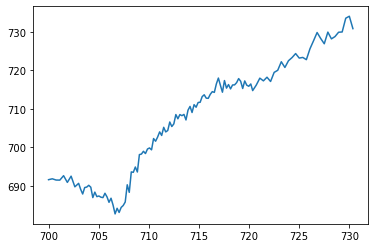

In [12]:
e0, I0 = np.loadtxt("Data/ALS_Toner/71214098_FigS3/Aligned/i0.xsp").T
plt.plot(Energy, I0)

In [13]:
normalized_img = data_img
for x in range(150):
    for y in range(150):
        normalized_img[x, y, :] = normalized_img[x, y, :] / I0

normalized_img = -normalized_img
normalized_img = normalized_img - np.min(normalized_img)
normalized_img = normalized_img / np.max(normalized_img)

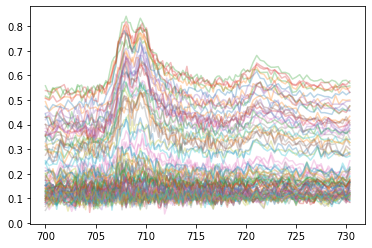

In [14]:
i = 0
for x in range(50, 100):
    for y in range(50, 100):
        plt.plot(Energy, normalized_img[x, y, :], alpha=0.3)
        i = i + 1
        if i == 100:
            break
    if i >= 100:
        break

# Mantis

In [15]:
mantis_xray.__version__
# open the GUI by using 'python -m mantis_xray' in the command prompt

'3.1.13'

# Background Subtract

In [48]:
indices = [i for i, e in enumerate(Energy) if e < 705]

for idx in [i for i, e in enumerate(Energy) if e > 716 and e < 718]:
    indices.append(idx)

for idx in [i for i, e in enumerate(Energy) if e > 726]:
    indices.append(idx)

In [49]:
def model_spectrum(params, x):
    return params[0] * np.arctan(params[1] * (x - 708.65)) \
         + params[2] * np.arctan(params[3] * (x - 721.65)) + params[4]

def bkgd_loss_function(params, x, ytrue, indices):    
    yfit = model_spectrum(params, x)
    sliced_yfit = np.array([yfit[i] for i in indices])
    sliced_ytrue = np.array([ytrue[i] for i in indices])
    error = mean_squared_error(sliced_yfit, sliced_ytrue)
    return error

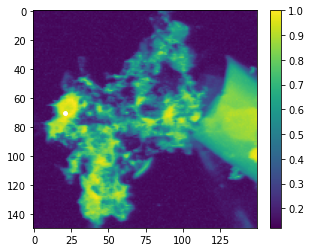

In [50]:
fig, ax = plt.subplots(figsize=(5, 4))
img = ax.imshow(np.flip(np.max(normalized_img, axis=2), axis=0), cmap=plt.cm.viridis, aspect='auto')
plt.colorbar(img)
ax.scatter(21, 70, marker='o', c='w', s=15)
plt.show()

In [51]:
x = np.array(Energy)
ytrue = normalized_img[70, 21]

params_0 = np.zeros(5) + 0.01
results = minimize(bkgd_loss_function, params_0, args=(x, ytrue, indices), method='SLSQP')
background_atan = model_spectrum(results['x'], x)

sliced_energy = np.array([Energy[i] for i in indices])
sliced_spectrum = np.array([ytrue[i] for i in indices])

m, b = np.polyfit(sliced_energy.T, sliced_spectrum.T, 1)
background_lin = m * np.array(Energy) + b 

a1, a2, b = np.polyfit(sliced_energy.T, sliced_spectrum.T, 2)
background_poly = a1 * np.array(Energy)**2 + a2 * np.array(Energy) + b 

Backgrounds = [background_atan, background_lin, background_poly]

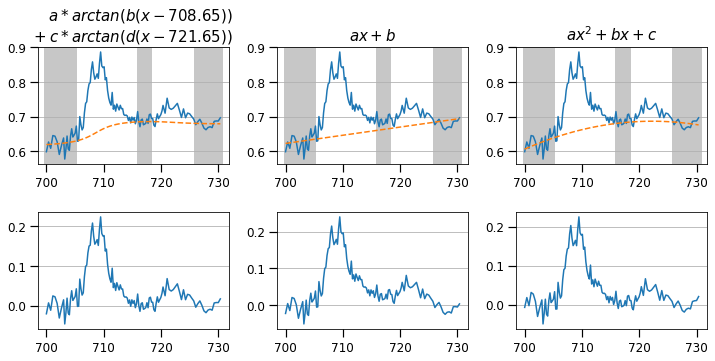

In [52]:
fig, axes = plt.subplots(figsize=(4 * 3, 2.6 * 2), ncols=3, nrows=2)
plt.subplots_adjust(wspace=0.25, hspace=0.4)

titles = ['$\quad a*arctan(b(x - 708.65))$' + '\n' +
          '$+\; c*arctan(d(x - 721.65))$', '$ax + b$', '$ax^2 + bx + c$']
for i, axl in enumerate(axes):
    for j, ax in enumerate(axl):
        ax.grid(axis='y')
        ax.tick_params(length=8, width=1.2, labelsize=12)
for i in range(3):
    axes[0, i].plot(x, ytrue)
    axes[0, i].plot(x, Backgrounds[i], '--')
    axes[1, i].plot(x, ytrue - Backgrounds[i])
    for idx in indices:
        axes[0, i].axvline(Energy[idx], c=plt.cm.tab20(15), zorder=1, lw=5)
    axes[0, i].set_title(titles[i], fontsize=15)
plt.show()

In [53]:
processed_img = normalized_img.copy()

background_subtract = True

if background_subtract:
    for x in range(150):
        for y in range(150):        
            params_0 = np.zeros(5) + 0.01
            results = minimize(bkgd_loss_function, params_0, 
                               args=(np.array(Energy), processed_img[x, y], indices), method='SLSQP')
            if results['success'] == False:
                print('ahhhhhhhh')
            background = model_spectrum(results['x'], np.array(Energy))

            processed_img[x, y, :] = processed_img[x, y, :] - background
else:
    processed_img = processed_img - np.min(processed_img)
    processed_img = processed_img / np.max(processed_img)

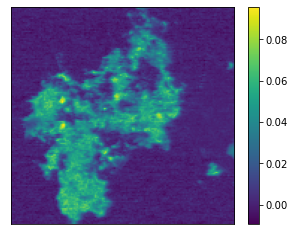

In [54]:
fig, ax = plt.subplots(figsize=(5, 4))
img = ax.imshow(np.flip(np.average(processed_img, axis=2), axis=0), cmap=plt.cm.viridis, aspect='auto')
plt.colorbar(img)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

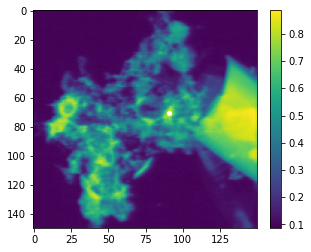

In [55]:
fig, ax = plt.subplots(figsize=(5, 4))
img = ax.imshow(np.flip(np.average(normalized_img, axis=2), axis=0), cmap=plt.cm.viridis, aspect='auto')
plt.colorbar(img)
ax.scatter(91, 70, marker='o', c='w', s=15)
plt.show()

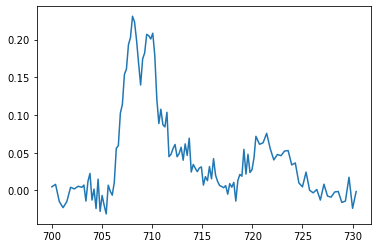

In [56]:
plt.plot(Energy, processed_img[70, 91, :])

In [57]:
flattened_data = [processed_img[x, y, :] 
                  for x in range(processed_img.shape[0]) 
                  for y in range(processed_img.shape[1])]

In [58]:
test = [normalized_img[x, y, :] 
        for x in range(processed_img.shape[0]) 
        for y in range(processed_img.shape[1])]

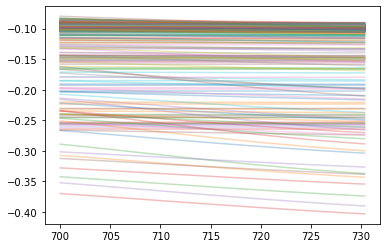

In [59]:
for i, spectrum in enumerate(flattened_data):
    plt.plot(Energy, spectrum - test[i], alpha=0.3)
    if i == 500:
        break

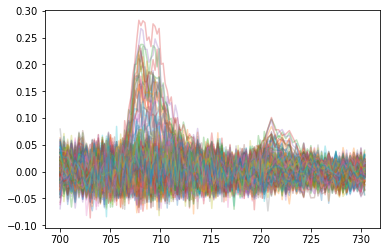

In [60]:
for i, spectrum in enumerate(flattened_data):
    plt.plot(Energy, spectrum, alpha=0.3)
    if i == 500:
        break

# Mask

In [61]:
mask_file = "Data/ALS_Toner/71214098_FigS3/Aligned/remove thick part.msk"
file = open(mask_file, 'r')
lines = file.readlines()
file.close()
width = 150

# convert mask into np array of booleans
feature_mask = []
for i, line in enumerate(lines):
    processed_line = line.strip()
    processed_line = processed_line.replace('O', '0').replace(' ', '1')
    for i in range(width - len(processed_line)):
        processed_line = processed_line + '1'
    processed_line = np.array(list(processed_line), dtype=int)
    feature_mask.append(processed_line)
feature_mask = np.flip(np.array(feature_mask), axis=0)

In [64]:
# threshold = 0.2 
threshold = 0.005

mask = np.ones((processed_img.shape[0], processed_img.shape[1]))
bool_arr = np.average(processed_img, axis=2) > threshold
bool_arr2 = feature_mask == 1
mask[bool_arr] = 0
mask[bool_arr2] = 1

filtered_data_dict = {(x, y): processed_img[x, y, :] 
                      for x in range(processed_img.shape[0]) 
                      for y in range(processed_img.shape[1])
                      if mask[x, y] == 0}

[]

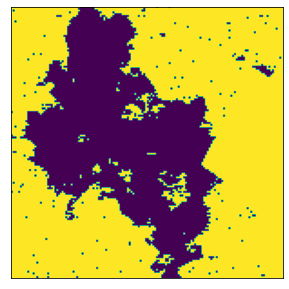

In [65]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(mask)
ax.set_xticks([])
ax.set_yticks([])

8196


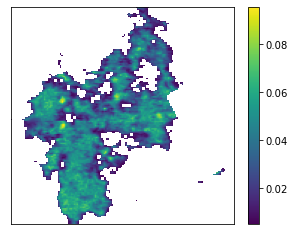

In [70]:
pts = np.array(list(filtered_data_dict.keys()))
filtered_data = np.array(list(filtered_data_dict.values()))
print(len(filtered_data))

filtered_img = np.ma.masked_array(np.average(processed_img, axis=2), mask=mask)

fig, ax = plt.subplots(figsize=(5, 4))
plt.subplots_adjust(wspace=0.1)
#img = ax.imshow(np.flip(np.average(processed_img, axis=2), axis=0), cmap=plt.cm.viridis, aspect='auto')
img = ax.imshow(np.flip(filtered_img, axis=0), cmap=plt.cm.viridis, aspect='auto')
plt.colorbar(img, ax=ax)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

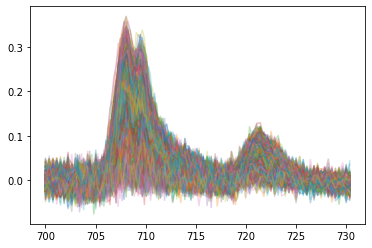

In [67]:
for i, spectrum in enumerate(filtered_data):
    plt.plot(Energy, spectrum, alpha=0.3)
    if i == 500:
        break

# Analysis

In [34]:
def make_scree_plot(data, n=5, threshold=0.95, color=plt.cm.Dark2(2),xy=(0.7, 0.3)):
    
    fig, ax = plt.subplots(figsize=(10, 6))
    pca = PCA()
    pca_components = pca.fit_transform(data)

    n_components = 0
    x = np.arange(n) + 1
    cdf = [np.sum(pca.explained_variance_ratio_[:i + 1]) for i in range(n)]
    for i, val in enumerate(cdf):
        if val > threshold:
            text = f"It takes {i + 1} PCs to explain\n{int(threshold*100)}% variance."
            print(text)
            ax.text(xy[0], xy[1], text, va='center', ha='center', fontsize=20,
                    transform=ax.transAxes)
            n_components = i + 1
            break

    ax.plot(x, cdf, 's-', markersize=12, fillstyle='none', color=color, linewidth=3)
    ax.plot(x, np.ones(len(x)) * threshold, 'k--', linewidth=3)
    xticks = np.arange(n) + 1
    
    plt.xticks(xticks, fontsize=18)
    plt.yticks(fontsize=18)
    #plt.ylim(min(cdf) - 0.005, 1.00)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.xlabel('Number of Parameters', fontsize=22)
    plt.ylabel(f'Cumultative\nExplained Variance', fontsize=22)
    ax.tick_params(direction='in', width=2, length=8)
    
    return n_components

In [71]:
scaled_data = np.array(filtered_data).copy()
scaled_data = scaled_data - np.min(scaled_data)
scaled_data = scaled_data / np.max(scaled_data)

It takes 3 PCs to explain
79% variance.


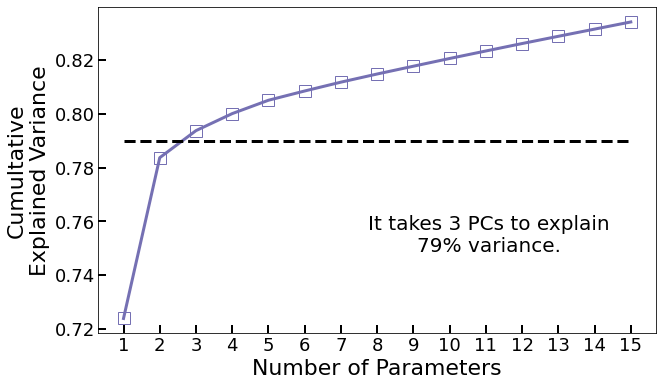

In [81]:
n_components = make_scree_plot(scaled_data, n=15, threshold=0.79)

In [82]:
pca = PCA(n_components=n_components)
pca = pca.fit(scaled_data)
projections = pca.transform(scaled_data)
print(projections.shape)
reconstructions = projections @ pca.components_ + pca.mean_

(8196, 3)


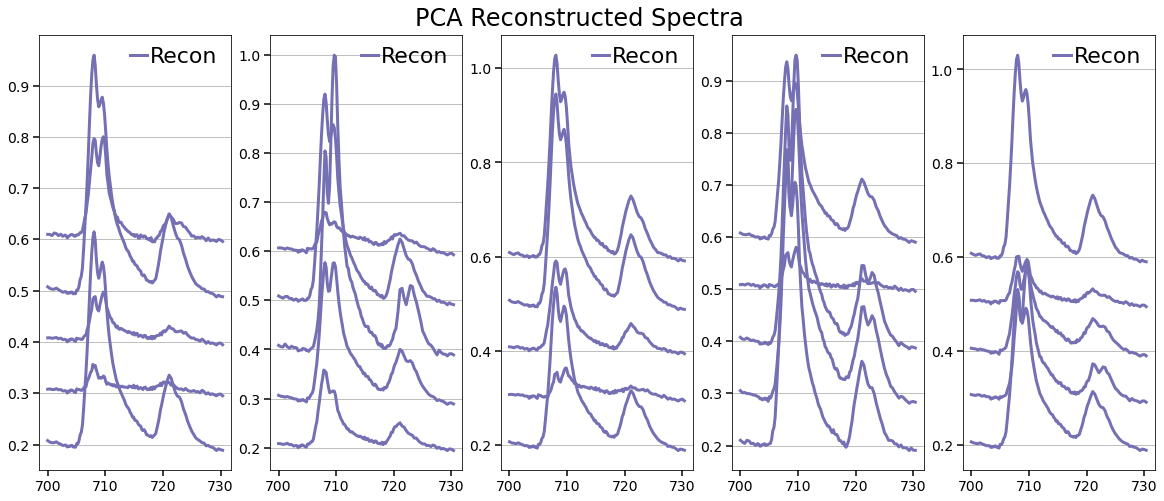

In [83]:
ncols = 5
fig, axes = plt.subplots(figsize=(4 * ncols, 8), ncols=ncols)
plt.subplots_adjust(wspace=0.2)

for col in range(ncols):
    ax = axes[col]
    random_indices = np.random.choice(np.arange(projections.shape[0]), size=5, replace=False)
    for i, idx in enumerate(random_indices):
        bottom = i * 0.1 #0.2
        if i == 0:
#             ax.plot(Energy, filtered_data[idx] + bottom, c='k', alpha=0.5, label='Data')
            ax.plot(Energy, reconstructions[idx] + bottom, c=plt.cm.Dark2(2), label='Recon', lw=3)
        else:            
#             ax.plot(Energy, filtered_data[idx] + bottom, c='k', alpha=0.5)
            ax.plot(Energy, reconstructions[idx] + bottom, c=plt.cm.Dark2(2), lw=3)
    ax.tick_params(length=6, width=1.5, labelsize=14)
    ax.grid(axis='y')
    ax.legend(fontsize=22, framealpha=0, handlelength=.8, labelspacing=.1, handletextpad=0.12,
              loc=1, bbox_to_anchor=(1.03, 1.02))

plt.suptitle('PCA Reconstructed Spectra', fontsize=24, y=0.93)
plt.show()

In [84]:
def get_cluster_avgs(spectra_dict, clusterizer):
    clusters = {i: [] for i in np.unique(clusterizer.labels_)}

    for i, key in enumerate(list(spectra_dict.keys())):
        spectrum = spectra_dict[key]
        color = clusterizer.labels_[i]
        clusters[color].append(spectrum)

    cluster_avgs = {key: np.average(clusters[key], axis=0) for key in list(clusters.keys())}
    return cluster_avgs

In [85]:
DRs = ['UMAP', 'PCA']
Reduced_spaces = []
Clusterizers = []
Cluster_avgs = []

for DR in DRs:
    if DR == 'UMAP':
        n_neighbors = 5
        n_dimensions = 2
        reducer = umap.UMAP(random_state=42, n_components=n_dimensions,
                            n_neighbors=n_neighbors, min_dist=0)
        reduced_space = reducer.fit_transform(projections)
        clusterizer = DBSCAN(eps=0.9, min_samples=1).fit(reduced_space)
        cluster_avgs = get_cluster_avgs(filtered_data_dict, clusterizer)
    else:
        n_clusters = 3
        reduced_space = projections
        clusterizer = KMeans(n_clusters=n_clusters, random_state=42).fit(reduced_space)
        cluster_avgs = get_cluster_avgs(filtered_data_dict, clusterizer)
    
    Reduced_spaces.append(reduced_space)
    Clusterizers.append(clusterizer)
    Cluster_avgs.append(cluster_avgs)
    print(f'There are {len(np.unique(clusterizer.labels_))} unique clusters in {DR}.')

There are 12 unique clusters in UMAP.
There are 3 unique clusters in PCA.


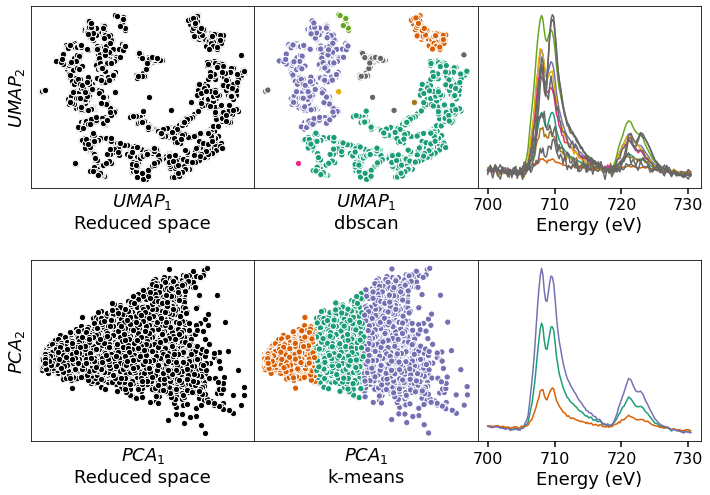

In [86]:
fig, axes = plt.subplots(figsize=(12, 8), ncols=3, nrows=2)
plt.subplots_adjust(wspace=0, hspace=0.4)

cmap = plt.cm.Dark2

for i, DR in enumerate(DRs):
    colors = [cmap(c) for c in Clusterizers[i].labels_]

    axes[i, 0].scatter(Reduced_spaces[i][:, 0], Reduced_spaces[i][:, 1], fc='k', ec='w', s=40)
    axes[i, 1].scatter(Reduced_spaces[i][:, 0], Reduced_spaces[i][:, 1], c=colors, ec='w', s=40)

    for j, pl in enumerate(Cluster_avgs[i].values()):
        axes[i, 2].plot(Energy, pl, c=cmap(j))

    for j, ax in enumerate(axes[i]):
        if j != 2:
            ax.set_xticks([])
            if j == 0:
                ax.set_ylabel(f'${DR}_2$', fontsize=18)
                ax.set_xlabel(f'${DR}_1$\nReduced space', fontsize=18)
            else:
                if DR == 'UMAP':
                    clustering = 'dbscan'
                else:
                    clustering = 'k-means'
                ax.set_xlabel(f'${DR}_1$\n{clustering}', fontsize=18)
        else:
            ax.tick_params(length=6, width=1.5, labelsize=16)
            ax.set_xlabel(f'Energy (eV)', fontsize=18)
        ax.set_yticks([])

plt.show()

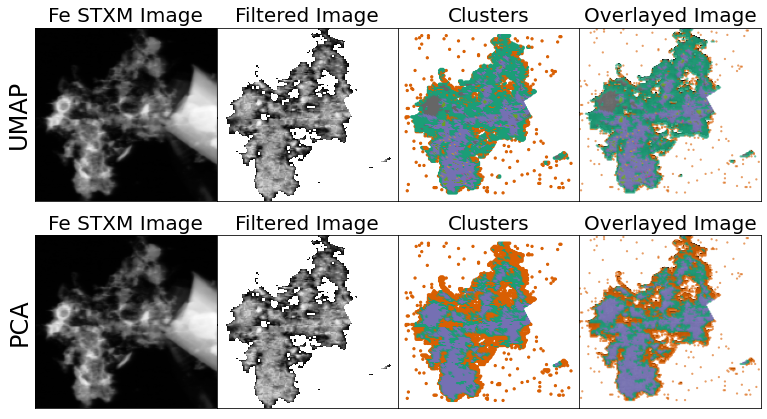

In [91]:
fig, axes = plt.subplots(figsize=(13, 7), ncols=4, nrows=2)
plt.subplots_adjust(wspace=0.0, hspace=0.2)

cmap = plt.cm.Dark2
filtered_img = np.ma.masked_array(np.average(processed_img, axis=2), mask=mask)

for i, DR in enumerate(DRs):
    colors = [cmap(c) for c in Clusterizers[i].labels_]

    axes[i, 0].set_title('Fe STXM Image', fontsize=20)
    axes[i, 0].imshow(np.log(np.flip(np.sum(data_img, axis=2), axis=0)), aspect='auto', 
                      cmap=plt.cm.Greys, origin='upper')
    
    axes[i, 1].set_title('Filtered Image', fontsize=20)
    axes[i, 1].imshow(np.flip(filtered_img, axis=0), aspect='auto', cmap=plt.cm.Greys_r, origin='upper')
    
    axes[i, 2].set_title(f'Clusters', fontsize=20)
    axes[i, 2].scatter(pts[:, 1], pts[:, 0], s=5, marker='o', color=colors, lw=1, ec=colors)
    
    axes[i, 3].set_title('Overlayed Image', fontsize=20)
    axes[i, 3].imshow(np.flip(filtered_img, axis=0), aspect='auto', cmap=plt.cm.Greys_r, origin='upper')
    axes[i, 3].scatter(pts[:, 1], -pts[:, 0] + 150, s=5, marker='o', color=colors, lw=0, alpha=0.6)
    
    axes[i, 0].set_ylabel(DR, fontsize=24)

for axl in axes:
    for ax in axl:
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()

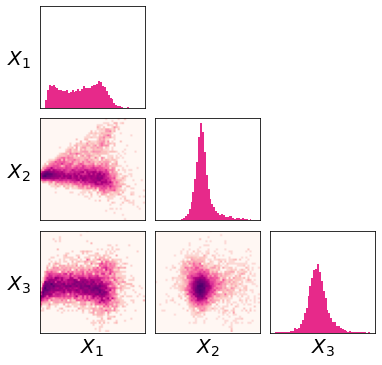

In [88]:
def make_triangle_plot(plot, data, color=plt.cm.Dark2(3), bins=50, tolerance=0.8, cmap=plt.cm.RdPu):
    
    n_dimensions = data.shape[1]
    fig, axes = plot

    for i in np.arange(n_dimensions):
        for j in np.arange(n_dimensions):
            ax = axes[i, j]
            if i == j:
                ax.hist(data[:, i], color=color, bins=bins)
                ax.set_xticks([])
                ax.set_yticks([])
            elif j < i:
                heatmap, xedges, yedges = np.histogram2d(data[:, j],
                                                         data[:, i],
                                                         bins=bins)
                extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
                ax.imshow(np.log(heatmap.T + tolerance), extent=extent, origin='lower', aspect='auto',
                          cmap=cmap)
                
                ax.set_xticks([])
                ax.set_yticks([])
            else:
                ax.axis('off')

            if j == 0:
                ax.set_ylabel(f'$X_{i + 1}$', fontsize=20, loc="center", rotation="horizontal")
                ax.yaxis.set_label_coords(-0.2, 0.37)
            if i == n_components - 1:
                ax.set_xlabel(f'$X_{j + 1}$', fontsize=20)

    max_y = 0
    for i in np.arange(n_dimensions):
        ax = axes[i, i]
        y_lim = ax.get_ylim()[1]
        if y_lim > max_y:
            max_y = y_lim
    for i in np.arange(n_dimensions):
        ax = axes[i, i]
        ax.set_ylim(0, max_y)
        
n_dimensions = reduced_space.shape[1]
fig, axes = plt.subplots(figsize=(2 * n_dimensions, 2 * n_dimensions),
                         ncols=n_dimensions, nrows=n_dimensions)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
make_triangle_plot((fig, axes), reduced_space)